# Kaggle Competition: Kobe Bryant Shot Selection

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

To avoid leakage, your method should only train on events that occurred prior to the shot for which you are predicting! Since this is a playground competition with public answers, it's up to you to abide by this rule.

https://www.kaggle.com/c/kobe-bryant-shot-selection/data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import style; style.use('ggplot')

In [2]:
data = pd.read_csv('data.csv')
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


## Plan:
- separate train and test data
    - use all labeled data for train, all unlabeled for test
    - remember to perform all preprocessing on BOTH train and test data together
- explore train data
    - determine trends
    - make visualizations
- determine relevant features
- preprocess relevant features
    - BOTH train and test together
- determine model type
    - test various models using cross validation
        - break train set into train and validation sets
    - record best model
- make predictions on test set using best model

Note) shot_made_flag is the label column

In [3]:
# separate train and test data
train = data[np.isnan(data.shot_made_flag) == False]
test = data[np.isnan(data.shot_made_flag)]

# remove shot_made_flag column from test (all nan)
test = test.drop(['shot_made_flag'], axis=1)

In [4]:
# confirm: 5000 test points, 1 less column in train
train.values.shape, test.values.shape

((25697, 25), (5000, 24))

In [5]:
list(test)

['action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_id',
 'team_name',
 'game_date',
 'matchup',
 'opponent',
 'shot_id']

## Features to save:
- action_type/combined_shot_type: type of shot
    - yes, only use one
    - one-hot encode from string
- game_event_id/game_id: specific game when shot was taken
    - maybe, only use one
    - one hot encode from int
- lat/lon: lattitude and longitude
    - maybe -- is this where in the country the game occured?
- loc_x/loc_y: x and y coordinates on court where shot was taken
    - yes
- minutes_remaining
    - yes
    - no preprocessing?
- period: quarter (or overtime, up to triple overtime (7))
    - yes
    - one hot encode from int
- playoffs
    - yes
    - already one hot encoded
- season: date range in years
    - yes
    - one-hot encode from string
- seconds_remaining
    - maybe -- range from 0-59, what is this referring to?
- shot_distance: from basket
    - yes
    - no preprocessing
- shot_type: 2pt or 3pt
    - yes
    - one hot encode
- shot_zone_area: left, right, center
    - yes
    - one hot encode
- shot_zone_basic: paint, mid-range, etc.
    - yes
    - one hot encode
- shot_zone_range
    - maybe (watch for double counting with distance)
    - one hot encode
- team_id/team_name: lakers (single value)
    - no
- game_date: year, month, day
    - no
- matchup/opponent
    - yes
    - matchup: opponent AND home (vs) or away (@)
    - opponent: just opponent
- shot_id: unique value for every shot
    - no

In [6]:
train.shot_zone_area.unique(), train.shot_zone_basic.unique() 

(array(['Left Side(L)', 'Left Side Center(LC)', 'Right Side Center(RC)',
        'Center(C)', 'Right Side(R)', 'Back Court(BC)'], dtype=object),
 array(['Mid-Range', 'Restricted Area', 'In The Paint (Non-RA)',
        'Above the Break 3', 'Right Corner 3', 'Backcourt',
        'Left Corner 3'], dtype=object))

In [7]:
# overall fg %
np.sum(train.shot_made_flag == 1) / train.shape[0]

0.44616103047048294

In [8]:
# 2pt fg %
np.sum(train[train.shot_type == '2PT Field Goal'].shot_made_flag == 1) / np.sum(train.shot_type == '2PT Field Goal')

0.4773477939364062

In [9]:
# 3pt fg %
np.sum(train[train.shot_type == '3PT Field Goal'].shot_made_flag == 1) / np.sum(train.shot_type == '3PT Field Goal')

0.32926829268292684

Text(0.5,1,'FG % vs Position')

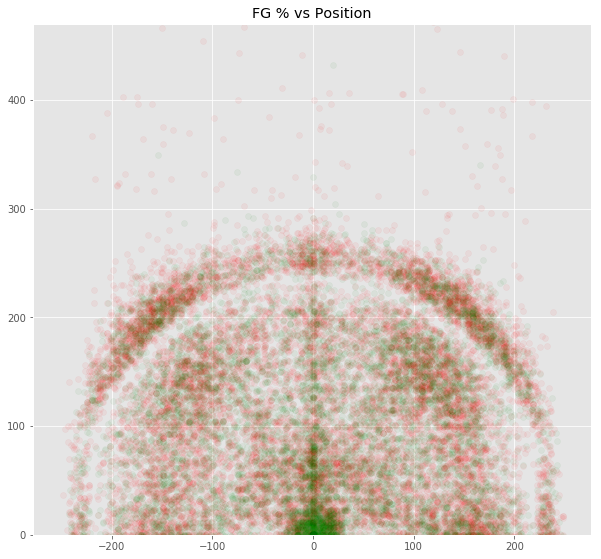

In [10]:
# setup court dimensions
plt.rcParams['figure.figsize'] = [10, 10 * (47 / 50)]

plt.scatter(train[train.shot_made_flag == 0].loc_x, 
            train[train.shot_made_flag == 0].loc_y,
            color='red', alpha=.05)

plt.scatter(train[train.shot_made_flag == 1].loc_x, 
            train[train.shot_made_flag == 1].loc_y,
            color='green', alpha=.05)

plt.ylim(0, 470)
plt.title('FG % vs Position')

In [11]:
np.max(train.loc_y)

791

In [12]:
# check FG % vs period
print('Period\tFG %')

for i in range(1, 5):
    temp = (np.sum(train[train.period == i].shot_made_flag == 1) / np.sum(train.period == i))
    print('%d\t%.2f' % (i, temp))

Period	FG %
1	0.47
2	0.45
3	0.45
4	0.41
